In [23]:
# Cell 1: Imports and Constants
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# Constants
ANALYSIS_PERIOD_YEARS = 20
ROLLING_WINDOW_DAYS = 365
CONFIDENCE_LEVEL = 0.95
RISK_FREE_RATE = 0.0439


In [24]:
# Cell 2: Data Download
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=365*ANALYSIS_PERIOD_YEARS)
etfs = ['PG','AMZN','IBM','WMT', 'IDTL.L'] # Update with your tickers
portfolio_weights = np.array([0.15,0.3,0.15,0.2,0.2])  # Update with your weights
daily_prices = yf.download(etfs, start=start_date, end=end_date)['Adj Close']


[*********************100%%**********************]  5 of 5 completed


In [25]:
# Cell 3: Returns Calculation
daily_returns = np.log(daily_prices / daily_prices.shift(1)).dropna()
portfolio_returns = (daily_returns * portfolio_weights).sum(axis=1)


In [26]:
# Calculate rolling returns
range_returns = portfolio_returns.rolling(window=ROLLING_WINDOW_DAYS).sum()
range_returns = range_returns.dropna()

# Calculate returns standard deviation
returns_std = range_returns.std()

# Calculate average daily return and annualize it
avg_daily_return = portfolio_returns.mean()
annualized_return_compound = np.exp(avg_daily_return * 365) - 1
annualized_return_simple = avg_daily_return * 365

# Sharpe ratio
sharpe_ratio = (annualized_return_compound - RISK_FREE_RATE) / returns_std


In [27]:
cumulative = (1 + portfolio_returns).cumprod()
rolling_max = cumulative.expanding().max()
drawdowns = cumulative / rolling_max - 1
max_drawdown = drawdowns.min()

In [28]:
# Cell 6: Diversification Score
correlation_matrix = daily_returns.corr()

# Calculate individual volatilities
volatilities = np.sqrt(np.diag(correlation_matrix))

# Weighted sum of individual volatilities
weighted_sum_vol = np.sum(portfolio_weights * volatilities)

# Calculate portfolio volatility
portfolio_vol = np.sqrt(np.dot(portfolio_weights, np.dot(correlation_matrix, portfolio_weights)))

# Calculate diversification ratio
div_ratio = weighted_sum_vol / portfolio_vol if portfolio_vol != 0 else 0

# Calculate as percentage of maximum possible diversification
max_ratio = np.sqrt(len(portfolio_weights))
div_percentage = (div_ratio / max_ratio) * 100


In [29]:
VaR = -np.percentile(range_returns, 100 - (CONFIDENCE_LEVEL * 100))
CVaR = -range_returns[range_returns <= -VaR].mean()

In [30]:
print("\nPortfolio Analysis Results:")
print("-" * 50)
print(f"Annualized Return (with compounding): {annualized_return_compound:.2%}")
print(f"Annualized Return (without compounding): {annualized_return_simple:.2%}")
print(f"Portfolio {ROLLING_WINDOW_DAYS} days Standard Deviation: {returns_std:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")

print("\nDiversification Analysis:")
print(f"Diversification Score: {div_ratio:.2f}")
print(f"Diversification Percentage: {div_percentage:.2f}%")

if div_ratio > 1.5:
    print("✓ Excellent diversification! Assets have favorable correlations.")
elif div_ratio > 1.2:
    print("✓ Good diversification. Consider additional decorrelation for improvement.")
else:
    print("! Low diversification. Your portfolio may be concentrated or highly correlated.")

print("\nRisk Metrics:")
print(f"VaR: There is a {(1-CONFIDENCE_LEVEL)*100:.1f}% chance that the portfolio loss")
print(f"     will exceed {VaR*100:.2f}% in {ROLLING_WINDOW_DAYS} days.")
print(f"CVaR: If the loss exceeds the VaR, the average loss is {CVaR*100:.2f}%")
print(f"      in {ROLLING_WINDOW_DAYS} days.")



Portfolio Analysis Results:
--------------------------------------------------
Annualized Return (with compounding): 15.53%
Annualized Return (without compounding): 14.44%
Portfolio 365 days Standard Deviation: 0.1095
Sharpe Ratio: 1.0170
Maximum Drawdown: -20.83%

Diversification Analysis:
Diversification Score: 1.62
Diversification Percentage: 72.50%
✓ Excellent diversification! Assets have favorable correlations.

Risk Metrics:
VaR: There is a 5.0% chance that the portfolio loss
     will exceed 6.58% in 365 days.
CVaR: If the loss exceeds the VaR, the average loss is 8.85%
      in 365 days.


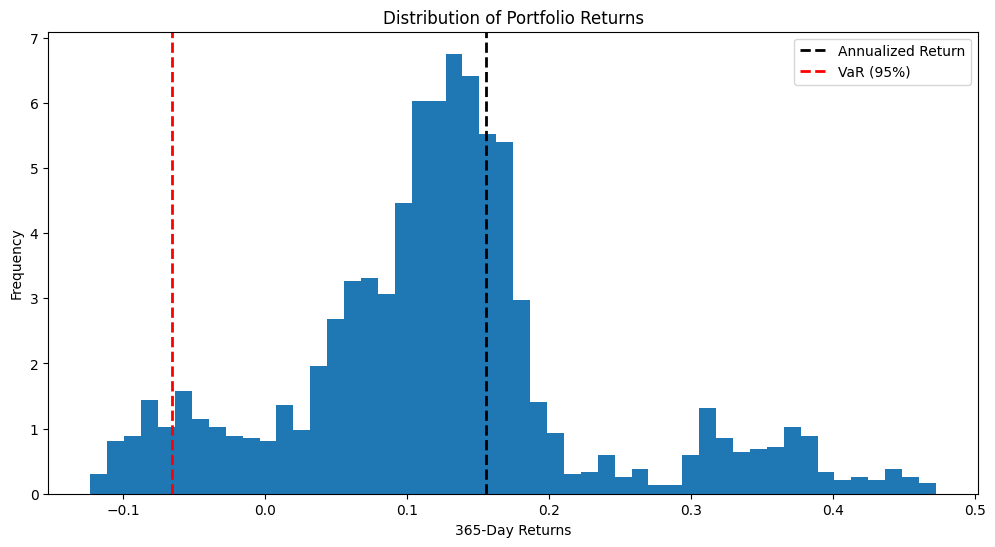

In [31]:
# Returns Distribution
plt.figure(figsize=(12, 6))
plt.hist(range_returns, bins=50, density=True)
plt.axvline(annualized_return_compound, color='black', linestyle='dashed', 
            linewidth=2, label='Annualized Return')
plt.axvline(-VaR, color='red', linestyle='dashed', 
            linewidth=2, label=f'VaR ({CONFIDENCE_LEVEL:.0%})')
plt.xlabel(f'{ROLLING_WINDOW_DAYS}-Day Returns')
plt.ylabel('Frequency')
plt.title('Distribution of Portfolio Returns')
plt.legend()
plt.show()